$\textbf{Data generation for QRNG using Boson Sampling}$

The implementation of the Boson Sampling scheme is gonna be done using  [Strawberryfields]

For the implementation, we prepare a five-mode input state including two single photon modes. We chose the two first modes for the single photon modes but it was shown that the position of the single photon modes does not change the output distribution.

Let us first generate a random complex unitary matrix from a $\textit{scipy}$ package which we will use for our linear interferometer. That unitary matrix will be fixed during a test cycle to ensure the results don't change all the time for better interpretation.

The input state will evolve through the linear interferometer characterized by the generated random unitary matrix and in the general case.  And the output state is obtained by counting the number of photons in the fock backend. This acts like a photon-number resolving detector counting the number of photons in each mode. We fix the number of photons detectable in each mode to 2 in our case for energy conservation criteria since there are only 2 photons in the input. This allows us to reduce the execution time of the code. 


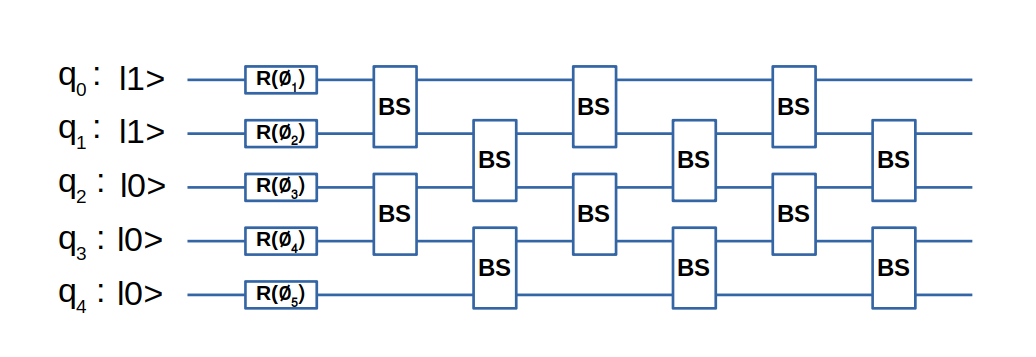

In this general case of $m$ single photons modes in a $n$ mode input, the number of output possibilities is of order $\binom{n+m-1}{m}$. For us, $m=2$ and $n=5$, hence the number of outputs is therefore $\binom{6}{2} = 15$. We choose this configuration mainly because the fock backend in strawberryfields implementation is very slow and the amount of time required to compute the circuit increase quickly with the possible amount of photons in each output mode. We do that by using the $\textit{cutoff_dim}$ for the backend options since by default each output mode is a Hilbert space of dimension infinite. The consequences of increasing the number of modes in the input or the number of single photons modes will be discussed in the code scalability part.

$\textbf{Random unitar matrix}$

In [1]:
from scipy.stats import unitary_group
import numpy as np

# creating a Haar random unitary Matrix using scipy
#--------------------------------------

# set the random seed 
# to ensure we get always the same random unitary matrix
np.random.seed(42)
#np.random.seed(177)
#np.random.seed(43)

# define the random complex unitary matrix of dimension 5 for the linear interferometer
U = unitary_group.rvs(5)

print(U)


[[ 0.20433962+0.04563164j -0.02361519-0.36173515j  0.26719021+0.04221819j
   0.27730975-0.07781071j -0.68043314+0.45347065j]
 [-0.0963199 -0.24753171j  0.55770976+0.58623734j  0.27070627+0.10086774j
  -0.16546696-0.31386425j -0.16575925+0.19471451j]
 [-0.19064203-0.50223399j -0.12383912-0.02478472j -0.14823601-0.67749106j
  -0.06714246-0.09148585j -0.36494647-0.26159983j]
 [-0.23131538+0.3037924j  -0.41811028+0.07338673j  0.43289245+0.01826825j
  -0.66041604+0.02964243j -0.2140438 -0.05855927j]
 [ 0.60294259-0.29613147j  0.04674194-0.12465382j -0.35544265+0.21984925j
  -0.58144165+0.05634298j -0.11566324+0.04174832j]]


$\textbf{State preparation for fock Boson Sampling }$

In [3]:
import strawberryfields as sf
from strawberryfields.ops import *

# States preparation
#--------------------------------------

# initialize a 5 mode program
boson_sampling = sf.Program(5)

# prepare the state
# 2 first modes are 1 photon state
# Other modes in vaccuum
with boson_sampling.context as q:
    for i in range (5):
        if i<2:
            Fock(1) | q[i]
        else :
            Vac     | q[i]

    # apply the unitary transformation
    Interferometer(U) | q
    
    # Measure the ouput state
    # Commented when getting the output probability distribution
    # not to collapse the superposition of output state
#    MeasureFock() | q


The measurement of the output state is only necessary if we want to get an output state among the superposition of all the output states. For now, it's commented because we're interested in looking at the probability distribution of the output states before post-processing.

$\textbf{Output probability distribution}$

Now we can calculate the probability of each possible output state. The output states are listed using energy conservation criteria, basically, all five mode states with a total of 2 photons. Make sure not to make a measurement in the circuit to ensure the output state doesn't collapse to one of the possible states when using fock backend.

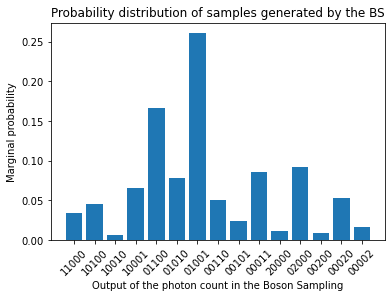

sum_prob= 0.9999999999999999


In [4]:
# Probability of the output states
#--------------------------

import matplotlib.pyplot as plt

# List all the possible outputs using energy conservation
output_states = [(1,1,0,0,0),(1,0,1,0,0), (1,0,0,1,0), (1,0,0,0,1),
          (0,1,1,0,0), (0,1,0,1,0), (0,1,0,0,1),
          (0,0,1,1,0), (0,0,1,0,1), (0,0,0,1,1),
          (2,0,0,0,0), (0,2,0,0,0),  (0,0,2,0,0),  (0,0,0,2,0),  (0,0,0,0,2)]

# simulate using the fock backend
eng = sf.Engine(backend="fock", backend_options={"cutoff_dim":3})
results = eng.run(boson_sampling)

# get the join Fock probability function
probs = results.state.all_fock_probs()

# create empty lists to store the output in the form of strings and the probabilty distributions
string = []
prob = []

# get the Fock probabilities for every output string
for i in output_states:
    string.append(''.join(str(j) for j in i)) # storing the output strings
    prob.append(probs[i]) # storing the probabilities

# plotting the histogram of the probability distribution
plt.bar(string, prob)
plt.xticks(rotation= 45)
plt.xlabel('Output of the photon count in the Boson Sampling')
plt.ylabel('Marginal probability')
plt.title('Probability distribution of samples generated by the BS')
plt.show()

# printing the sum of porbabilities to ensure we haven't missed any states
# should be around 1
print("sum_prob=",sum(prob))

$\textbf{Shanon entropy}$

In order to to quantify how random the output distribution is, we use some quantifiers such as the Shanon entropy $H = -\sum_{k} p_k \log(p_k)$ and  the minimum entropy $H_{min} = -\log \left(max_k\{p_k\} \right)$ with gives us the minimum of hitting, with  $p_k$ a probability distribution. Since we expect to use the Shannon entropy to compare our output distribution with similar ones with a probability of different dimensions, it is natural to also print out the normalized Shannon entropy with its maximum value $H_{max}=-\log(d_k)$ with $d_k$ the dimension of the probability distribution. The minimum entropy will allow us to get the probability of hitting the first guess from a random variable with a known probability distribution ($2^{-H_{min}}$). 

In [5]:
# define the Shannon entropy
def shanon_entropy(prob):
    entropy = 0
    for i in range(len(prob)):
        entropy -= prob[i]*np.log(prob[i])
    return entropy

# define the minimum entropy
def min_entropy(prob):
    entropy = -np.log(max(prob))
    return entropy

# probability of hitting hiting the first guess
# from  a random variable with a known probability distribution
def prob_hiting_first_guess(prob):
    return 2**(-min_entropy(prob))

In [6]:
# Printing out the values for our output probability distribution
print ("The value of the Shannon entropy is", shanon_entropy(prob))
print("The value of the maximum of Shannon entropy is",np.log(len(prob)))
print("The value of the normalized Shannon entropy is",shanon_entropy(prob)/np.log(len(prob)))
print("The value of the minimum entropy is", min_entropy(prob))
print("The probability of hitting hiting the first guess is from  a random variable with a known probability distribution", round(prob_hiting_first_guess(prob),5))

The value of the Shannon entropy is 2.3025832754112483
The value of the maximum of Shannon entropy is 2.70805020110221
The value of the normalized Shannon entropy is 0.8502734825499425
The value of the minimum entropy is 1.3440475183577927
The probability of hitting hiting the first guess is from  a random variable with a known probability distribution 0.39391


$\textbf{Biased distribution}$

To check if the output distribution of string is unbiased, we need to check if the probability of every bit being 0 or 1 is 0.5. Let us for that replace every bit value '2' with '1' to ensure a binary string.

The probability distribution for the i-th digit of the produced string
P(x[ 0 ]=0)= 0.8362742944149021 |P(x[ 0 ]=1)= 0.1637257055850979
P(x[ 1 ]=0)= 0.367115644778468 |P(x[ 1 ]=1)= 0.6328843552215319
P(x[ 2 ]=0)= 0.7046722697972451 |P(x[ 2 ]=1)= 0.2953277302027547
P(x[ 3 ]=0)= 0.7265471943874532 |P(x[ 3 ]=1)= 0.2734528056125466
P(x[ 4 ]=0)= 0.5470377755513843 |P(x[ 4 ]=1)= 0.45296222444861556


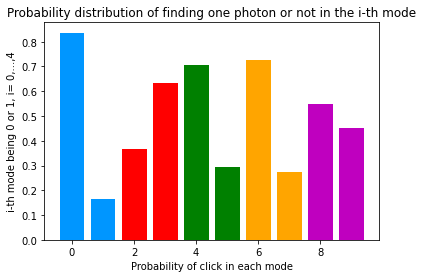

In [7]:
# The purpose of this cell is to get the probability of 0 or 1 in each bit

# this loop is to replace every bit value 2 with 1 to ensure a bianry string
for i in range(len(string)):
    for j in range(len(string[i])):
        if string[i][j]=='2':
            aa=list(string[i])
            aa[j]='1'
            aastr=''.join(aa)
            string[i]=aastr

print('The probability distribution for the i-th digit of the produced string')

x0 = 0 # generating the axis for the probability of having 0 in each bit
x1 = 1 # generating the axis for the probability of having 1 in each bit
col =['#0096FF','r','g','orange','m'] # color list

# this loop allows to contruct the probability of having 0 and 1 in each bit
ss=string
for j in range(len(string[0])):
    prob0=0
    prob1=0
    for i in range(len(string)):
        if ss[i][j]=='0':
            prob0+=(prob[i])
        elif ss[i][j]=='1':
            prob1+=(prob[i])
    
    # printing the value of the probabilities
    print('P(x[',j,']=0)=',prob0,'|P(x[',j,']=1)=',prob1)
    # plotting the histograms successively in the loop
    plt.bar(x0, prob0, color=col[j] )
    plt.bar(x1,prob1,color=col[j])
    x0 +=2 # incrementing the axis
    x1 +=2
    
plt.xlabel('Probability of click in each mode')
plt.ylabel('i-th mode being 0 or 1, i= 0,...,4')
plt.title('Probability distribution of finding one photon or not in the i-th mode')
plt.show()

So boson sampling doesn't produce unbiased strings because as we can see, the probability of having either '0' or '1' in each bit string is not 0.5. Hence the use of von-Neuman post-processing to get an unbiased distribution of output. 

$\textbf{Measurement results}$

For that, let us get some output data that will be processed into another notebook. To get the measurement results, we use the fock backend (photon counting). Since each output mode can theoretically have an infinite number of photons, we use $\textit{cutoff_dim}$ to fix the maximum number of photons in each mode. In our case, 2 is enough for energy conservation considerations (so $\textit{"cutoff_dim":3}$). We execute the boson sampler $n=600$ times to generate 600 output states for different values of seed (meaning different random unitaries) and we measure the time it takes to generate them.

In [4]:
### Measurement results 
###Don't forget to uncomment the measurement operation in the state preparation cell (cell 2)
# -----------------------------
import time

# get the start time
st = time.time()

# Get output samples using fock backend (photon counting)
# cutoff_dim -1 is the maximimum number of photon that can be detected in each output mode
eng = sf.Engine(backend="fock", backend_options={"cutoff_dim":3})

n = 600 # number of samples

# defining a function that can be used to get outputs
def output_before_pp():
    results=eng.run(boson_sampling)
    return np.ravel(results.samples) # numpy ravel is used to flatten the array obtained

# store the samples into a list
sample=[output_before_pp() for i in range(n)]

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

#Be careful when running this because it might take some time.


Execution time: 13.907448291778564 seconds


It took around 600s = 10 mn to generate the 600 samples meaning a rate of 1 sample per second.

The next cell takes the $textit{sample}$ list and saves it in a CVS archive, which name is formatted using the number of the seed and the number of photons. Be careful to change the name of the file if you don't want to erase the files that are already in there. Every run is of 600 samples.

In [6]:
import numpy as np
  
# from the numpy module
import numpy as np
  
# from the numpy module
# sava the datas into an cvs file
np.savetxt("data/seed42_2photon.csv", 
           sample,
           delimiter =", ", 
           fmt ='% s')

As we said earlier, these data will be used to assess the quality of the Quantum Random Number Generator based on our boson sampling process, after post-processing.

$\textbf{Code Improvement and code scalibility}$

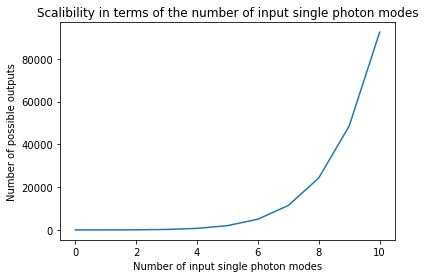

In [9]:
import scipy.special
from scipy.special import comb
import numpy as np
import matplotlib.pyplot as plt

# plotting the 
n = 10 # fixing the number of
m = np.arange(0,11,1)
plt.plot(m,scipy.special.comb(n+m-1,m))
plt.xlabel('Number of input single photon modes')
plt.ylabel('Number of possible outputs')
plt.title('Scalibility in terms of the number of input single photon modes')
plt.show()

In the general case $m$ single photons modes in a $n$ mode input, the number of output possibilities is of order $\binom{n+m-1}{n}$. For a fixed number of input modes $m$, the number of output possibilities increases with the single photon modes $n$ and for a fixed number of photons.

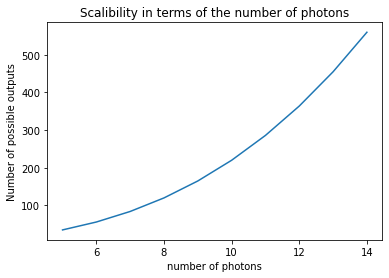

In [3]:
n = np.arange(5,15,1)
m = 3
plt.plot(n,scipy.special.comb(n+m-1,m))
plt.xlabel('Number of input modes')
plt.ylabel('Number of possible outputs')
plt.title('Scalibility in terms of the number input modes')
plt.show()

The code can also be improved to better suit the case of more input modes, by improving the detection scheme. For now, our detection scheme is using the fock backend to count the number of photons in each output mode. In our implementation, despite having fixed the maximum number of photons that can be detected in each mode, depending on the number of input bits, we're already conscient that increasing the input modes will exponentially increase the code execution time. That was already noticeable by having three input photons instead of 2. That photon counting process is not actually necessary. For the von-Neuman post-processing, all we need to know for a sample is, if there is a photon in a mode or not, not necessarily the number of photons in the mode. The ideal case would be then to implement a type of trigger detector (bucket detector for example), which will only check the presence of a photon in a mode or not. This improvement will allow for faster random number generators even for the case with a large number of input modes.

$\textbf{Hardware scalibility}$

As we stated previously, the process of generating a single photon through SPDC (Spontaneous Parametric Down Conversion) or SFWM (Spontaneous Four-Wave Mixing) are both probabilistic (non-deterministic). With a strong coherent pump, a pair of photons is generated through SPDC for example (signal and idler photon). A photodetector is put on the signal where a photon detection will ensure we know there is a photon in the idler due to quantum correlations. The idler photon will be rooted to one of the inputs of the boson samplers. The generated state in this case for example is a superposition of

$$
|\psi_{SPDC}\rangle = \frac{1}{\cosh(r)} \sum_{n=0}^{\infty}\tanh^{2n}(r) |{n_s n_i}\rangle
$$

We can see with this distribution that the probability of getting no photon is the highest and the probability of generating the necessary exact pair of photons for the process to work is not unit. As we increase the number of photons needed to run a boson sampler with a higher number of modes, the joint probability of generating simultaneously a single photon on every necessary input mode gets smaller and smaller as the number of one photon modes increases (temporal mismatch). Making this solution of boson sampling very hard to implement physically on a large scale (for more and more modes). With a very low probability of generating simultaneous single photons from every input source, one needs to wait exponential long times for that event to happen, rendering the advantage over classical computation obsolete.

An alternative to that is using a Gaussian boson sampler where squeezed modes are used. That is what we are going to talk about in the next notebook..